# Localized analysis: band-pass filtering, Hilbert transform

We investigate how band-pass filtering and hilbert transform can be combined in order to extract a tidal signal from the sum of a tidal signal and a low-frequency signal.
See the [main notebook](main.ipynb) for descriptions of the signal and of the filtering and hilbert transforms.

The tidal signal is non-stationary for now, i.e. there is no stationary contribution.

In [1]:
import xarray as xr
import numpy as np

from scipy import signal
import scipy.ndimage as im

import matplotlib.pyplot as plt

from sympy import Symbol, pi, atan, factor, lambdify

import sstats.hfreq as hf
import sstats.tseries as ts
import sstats.sigp as sigp
from sstats import get_cmap_colors

rad = 2 * np.pi

print_figs = True

## filter design: firwin vs firwin2

Should probably include alternatives (equivalent to harmonic analysis over a fixed window)

[Link to scipy documentation](https://docs.scipy.org/doc/scipy/reference/tutorial/signal.html#filter-design)

In [2]:
sigma = 2.0
hbandwidth = 0.3  # half bandwidth
T_window = 50  # window size in days
dt = 1 / 24

F = {}
for f in ["firwin", "firwin2"]:

    h, t = sigp.bpass_filter(sigma, hbandwidth, int(T_window / dt), dt, f)
    h_hat, w = sigp.filter_response(h, dt)

    F[f] = dict(h=h, t=t, h_hat=h_hat, w=w, hbandwidth=hbandwidth, sigma=sigma)

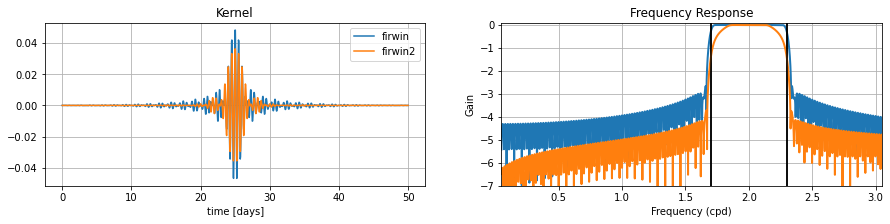

In [3]:
fig, axes = plt.subplots(1, 2, figsize=(15, 3))
ax = axes[0]
for ftype, f in F.items():
    ax.plot(f["t"], f["h"], label=ftype)
ax.grid()
ax.set_xlabel("time [days]")
ax.set_title("Kernel")
ax.legend()

ax = axes[1]
for ftype, f in F.items():
    ax.plot(f["w"], np.log10(abs(f["h_hat"])), linewidth=2, label=ftype)
    ax.axvline(f["sigma"] - f["hbandwidth"], color="k")
    ax.axvline(f["sigma"] + f["hbandwidth"], color="k")
ax.set_xlabel("Frequency (cpd)")
ax.set_ylabel("Gain")
ax.set_title("Frequency Response")
# ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 3.05)
ax.grid(True)

### sensitivity to kernel length

with firwin

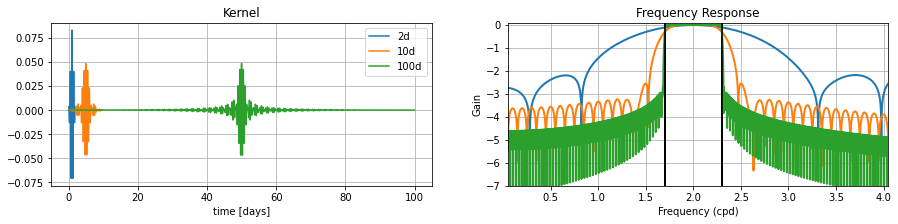

In [4]:
sigma = 2.0
hbandwidth = 0.3

N = [2 * 24, 10 * 24, 100 * 24]

FN = {}
for n in N:

    h, t = sigp.bpass_filter(sigma, hbandwidth, n, dt, "firwin")
    h_hat, w = sigp.filter_response(h, dt)

    # hbandwidth, sigma are cpd. Later on there are quasi systematically (except for plots)
    # in radians per days
    # in formulas typically, these values will have to be converted in radians per days
    FN[n] = dict(h=h, t=t, h_hat=h_hat, w=w, hbandwidth=hbandwidth, sigma=sigma)


fig, axes = plt.subplots(1, 2, figsize=(15, 3))
ax = axes[0]
for n, f in FN.items():
    ax.plot(f["t"], f["h"], label="{:d}d".format(int(n / 24)))
ax.grid()
ax.set_xlabel("time [days]")
ax.set_title("Kernel")
ax.legend()

ax = axes[1]
for n, f in FN.items():
    ax.plot(
        f["w"],
        np.log10(abs(f["h_hat"])),
        linewidth=2,
        label="{:d}d".format(int(n / 24)),
    )
    ax.axvline(f["sigma"] - f["hbandwidth"], color="k")
    ax.axvline(f["sigma"] + f["hbandwidth"], color="k")
ax.set_xlabel("Frequency (cpd)")
ax.set_ylabel("Gain")
ax.set_title("Frequency Response")
# ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 4.05)
# ax.set_xlim(1.5, 2.5)
ax.grid(True)

---

## Hilbert transform

### apply band-passed filter and hilbert transform

In [5]:
# generate synthetic data

u_low = hf.low_frequency_signal()
u_high = hf.high_frequency_signal()


def rename_attrs(da, **kwargs):
    """rename attributes"""
    for k_new, k_old in kwargs.items():
        da = da.assign_attrs(**{k_new: da.attrs.pop(k_old)})
    return da


def tseries(kind, params={}, **kwargs):
    _kwargs = dict(
        time=(1000, 1 / 24),
        seed=0,
    )
    _kwargs.update(**kwargs)
    #               T=10.,
    if kind == "high":
        p = dict(U=[0.01, 0.1, 1.0], T=10, sigma=2.0 * rad)
        p.update(**params)
        da = u_high.generate_tseries(params=p, **_kwargs).persist()
        da = rename_attrs(da, T_high="T").rename(U="U_high")
    else:
        p = dict(T=10)
        p.update(**params)
        da = u_low.generate_tseries(params=p, **_kwargs).persist()
        da = rename_attrs(da, T_low="T", U_low="U")
    return da


# actually generate time series
da_high = tseries("high")
da_low = tseries("low")
ds = xr.merge([da_high, da_low], combine_attrs="no_conflicts")

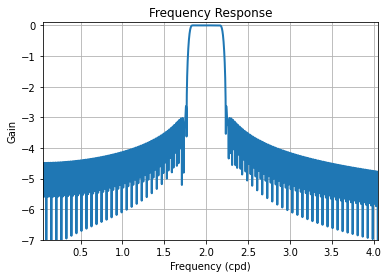

In [6]:
sigma, hbandwidth = ds.sigma, 2 / ds.T_high

ds, h, h_hat, w = sigp.bpass_demodulate(ds, sigma / rad, hbandwidth, T_window)

fig, ax = plt.subplots(1, 1)

ax.plot(w, np.log10(abs(h_hat)), linewidth=2)
ax.axvline(sigma - hbandwidth, color="k")
ax.axvline(sigma + hbandwidth, color="k")
ax.set_xlabel("Frequency (cpd)")
ax.set_ylabel("Gain")
ax.set_title("Frequency Response")
# ax.set_ylim(-0.05, 1.05)
ax.set_ylim(-7, 0.1)
ax.set_xlim(0.05, 4.05)
# ax.set_xlim(1.5, 2.5)
ax.grid(True)

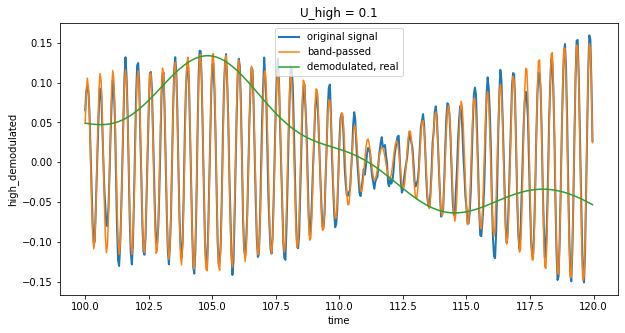

In [7]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ds = ds.sel(U_high=0.1).where((ds.time >= 100) & (ds.time < 120))
np.real(_ds["high"]).plot.line(x="time", lw=2, label="original signal")
np.real(_ds["high_bpassed"]).plot.line(x="time", label="band-passed")
np.real(_ds["high_demodulated"]).plot.line(x="time", label="demodulated, real")
plt.legend()

In [8]:
# variance of the residual
diff_high = _ds["high"] - np.real(_ds["high_bpassed"])
print("Residual variance = {:.2e}'".format(float(diff_high.var() / _ds["high"].var())))

Residual variance = 2.88e-02'


### inspect with spectra: high, high_bpassed, residual

Original variance:
[5.05063900e-05 4.71183624e-03 4.65064784e-01]
From spectra:
[4.83069463e-05 4.64973743e-03 5.31643296e-01]
Ratio (spectra/original):
[0.95645217 0.98682068 1.14315965]


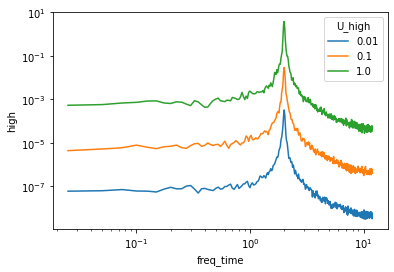

In [11]:
v = "high"
ps = sigp.xrft_spectrum(ds[v])
ps.where(ps.freq_time > 0).plot.line(x="freq_time", xscale="log", yscale="log")

# check Parseval:
print("Original variance:")
var_original = ds[v].var("time").values
print(var_original)
print("From spectra:")
var_spectra = np.trapz(ps.values, ps.freq_time.values)
print(var_spectra)
print("Ratio (spectra/original):")
print(var_spectra / var_original)

In [12]:
spectra = xr.merge(
    [sigp.xrft_spectrum(np.real(ds[v])) for v in ds]
    + [
        sigp.xrft_spectrum((ds[v] - np.real(ds[v + "_bpassed"])).rename(v + "_diff"))
        for v in ["high", "low"]
    ],
)

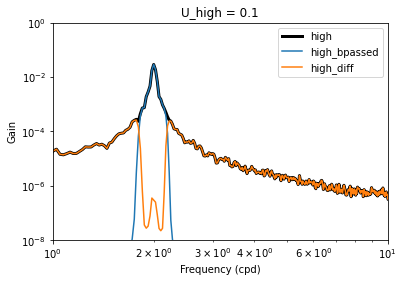

In [13]:
v = "high"

_ds = spectra.sel(U_high=0.1).where(spectra.freq_time > 0)

fig, ax = plt.subplots(1, 1)  # figsize=(15,3)

k = dict(x="freq_time", xscale="log", yscale="log", ax=ax)
_ds[v].plot.line(lw=3, color="k", label=v, **k)
_ds[v + "_bpassed"].plot.line(label=v + "_bpassed", **k)
_ds[v + "_diff"].plot.line(label=v + "_diff", **k)

ax.axvline(sigma - hbandwidth, color="k", ls="--")
ax.axvline(sigma + hbandwidth, color="k", ls="--")
ax.set_xlabel("Frequency (cpd)")
ax.set_ylabel("Gain")
ax.set_xlim(1e0, 1e1)
ax.set_ylim(1e-8, 1e0)
ax.legend()

### focus on the enveloppe 

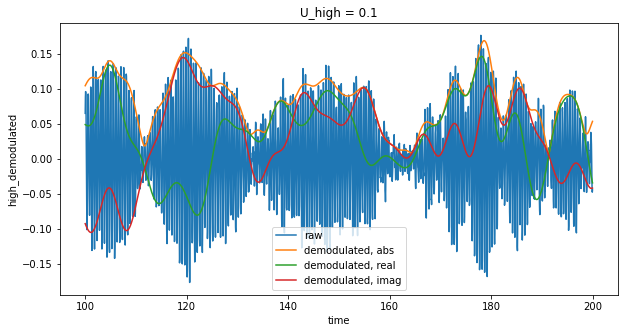

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))
_ds = ds.sel(U_high=0.1).where((ds.time >= 100) & (ds.time < 200))
_ds["high"].plot.line(x="time", label="raw")
np.abs(_ds["high_demodulated"]).plot.line(x="time", label="demodulated, abs")
np.real(_ds["high_demodulated"]).plot.line(x="time", label="demodulated, real")
np.imag(_ds["high_demodulated"]).plot.line(x="time", label="demodulated, imag")
plt.legend()

In [15]:
# check phase of synthetic signal
# np.abs(_ds["high_demodulated"]).plot.line(x='time', label="demodulated, real")
# xr.apply_ufunc(np.angle, _ds["high_demodulated"], dask="parallelized").plot.line(x='time', label="demodulated, real")

### sentivity to the filter bandwidth

An halfbandwidth of $2/T_{high}$, i.e. a bandwidth of $1/T_{high}$ is sufficient to capture modulations vizually:

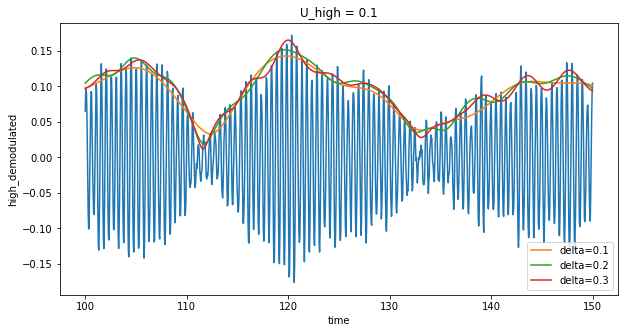

In [16]:
fig, ax = plt.subplots(1, 1, figsize=(10, 5))

_ds = ds.sel(U_high=0.1).where((ds.time >= 100) & (ds.time < 150))
_ds["high"].plot.line(x="time")

for hbandwidth in [1 / ds.T_high, 2 / ds.T_high, 3 / ds.T_high]:
    ds, h, h_hat, w = sigp.bpass_demodulate(
        ds[["high", "low"]], sigma / rad, hbandwidth, T_window
    )
    _ds = ds.sel(U_high=0.1).where((ds.time >= 100) & (ds.time < 150))
    np.abs(_ds["high_demodulated"]).plot.line(
        x="time", label="delta={}".format(hbandwidth)
    )
plt.legend()

### autocorrelations of the enveloppe

Don't forget there will be a factor 2 between the autocorrelation of the demodulated time series and that of the full signal

In [17]:
hbandwidth = 1 / ds.T_high
ds, h, h_hat, w = sigp.bpass_demodulate(
    ds[["high", "low"]], sigma / rad, hbandwidth, T_window
)

In [18]:
def autocorrelations(ds, combine=False):
    V = ["high", "low"]
    if combine:
        ds["sum"] = ds["high"] + ds["low"]
        ds["sum_demodulated"] = ds["high_demodulated"] + ds["low_demodulated"]
        V = V + ["sum"]
    R = []
    for v in V:
        R.append(
            (
                sigp.correlate(ds[v + "_demodulated"], ds[v + "_demodulated"])
                .rename(v)
                .to_dataset()
                .rename({"lags": "tau"})
            )
        )
    return xr.merge(R)


R = autocorrelations(ds)
# R

(0.0, 200.0)

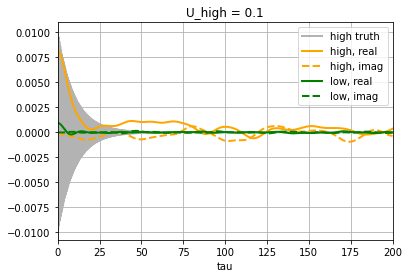

In [21]:
_ds = R.sel(U_high=0.1)

_ds["high_true"] = u_high.evaluate_autocorrelation(
    U=_ds.U_high, sigma=sigma, T=ds.T_high, tau=_ds.tau
)

fig, ax = plt.subplots(1, 1)
(2 * _ds["high_true"]).plot.line(x="tau", ax=ax, color="0.7", lw=2, label="high truth")
np.real(_ds["high"]).plot.line(x="tau", ax=ax, color="orange", lw=2, label="high, real")
np.imag(_ds["high"]).plot.line(
    x="tau", ax=ax, color="orange", lw=2, ls="--", label="high, imag"
)
np.real(_ds["low"]).plot.line(x="tau", ax=ax, color="green", lw=2, label="low, real")
np.imag(_ds["low"]).plot.line(
    x="tau", ax=ax, color="green", lw=2, ls="--", label="low, imag"
)
ax.grid()
ax.legend()
ax.set_ylabel(None)
# ax.set_xlim(0,10)
ax.set_xlim(0, 200)

### sensibility to filter bandwidth

(0.0, 40.0)

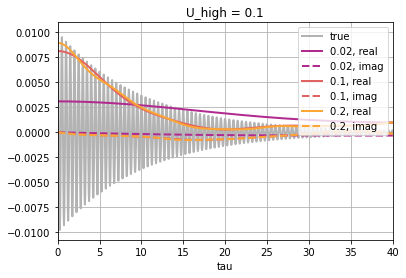

In [22]:
fig, ax = plt.subplots(1, 1)

hbandwidths = [0.2 / ds.T_high, 1 / ds.T_high, 2 / ds.T_high]
colors = get_cmap_colors(len(hbandwidths) + 2, cmap="plasma")

_ds["high_true"] = u_high.evaluate_autocorrelation(
    U=_ds.U_high, sigma=sigma, T=ds.T_high, tau=_ds.tau
)
(2 * _ds["high_true"]).plot.line(x="tau", ax=ax, color="0.7", lw=2, label="true")

for hbandwidth, c in zip(hbandwidths, colors[2:]):

    ds, h, h_hat, w = sigp.bpass_demodulate(
        ds[["high", "low"]], sigma / rad, hbandwidth, T_window
    )
    R = autocorrelations(ds)

    _ds = R.sel(U_high=0.1)

    np.real(_ds["high"]).plot.line(
        x="tau", ax=ax, color=c, lw=2, label="{}, real".format(hbandwidth)
    )
    np.imag(_ds["high"]).plot.line(
        x="tau", ax=ax, color=c, lw=2, ls="--", label="{}, imag".format(hbandwidth)
    )
    # _ds['low'].plot.line(x='tau', ax=ax, color='green', lw=2, label='low estimate')


ax.grid()
ax.legend(loc="upper right")
ax.set_ylabel(None)
ax.set_xlim(0, 40)

### autocorrelation of combined timeseries: low + high

In [19]:
hbandwidth = 2 / ds.T_high
ds, h, h_hat, w = sigp.bpass_demodulate(
    ds[["high", "low"]], sigma / rad, hbandwidth, T_window
)

R = autocorrelations(ds, combine=True)

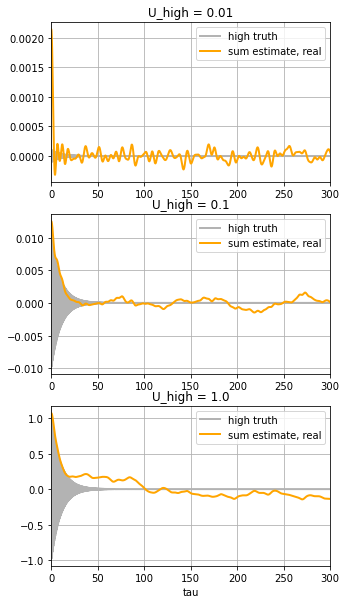

In [20]:
_u_high = R.U_high.values
fig, axes = plt.subplots(_u_high.size, 1, figsize=(5, 10))

for _u, ax in zip(_u_high, axes):

    _ds = R.sel(U_high=_u)

    _ds["high_true"] = u_high.evaluate_autocorrelation(
        U=_u, sigma=sigma, T=ds.T_high, tau=_ds.tau
    )

    (2 * _ds["high_true"]).plot.line(
        x="tau", ax=ax, color="0.7", lw=2, label="high truth"
    )
    np.real(_ds["sum"]).plot.line(
        x="tau", ax=ax, color="orange", lw=2, label="sum estimate, real"
    )
    # _ds['low'].plot.line(x='tau', ax=ax, color='green', lw=2, label='low estimate')
    ax.grid()
    ax.legend()
    ax.set_ylabel(None)
    ax.set_xlim(0, 300)
    if _u != _u_high[-1]:
        ax.set_xlabel("")

### correlated real, imag demodulated signal :

- spring-neap beating

**!!! uncomplete need to ajust filtering bandwidth with respect to spring/neap frequency separation !!!**


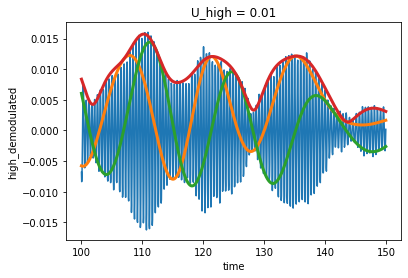

In [21]:
## generate slightly different harmonics

# random
da_high = tseries("high", params=dict(sigma=2.0 * rad, T=100), seed=0)
da_high_bis = tseries(
    "high", params=dict(sigma=2.0 * (1 + 1 / 28) * rad, T=100), seed=5
)

# or stationary signal
# ratio = 1.
# _da = da_high
# beating = (np.cos(rad*_da.sigma*_da.time)
#           + ratio*np.cos(rad*_da.sigma*(1+1/28) *_da.time)
#          )/np.sqrt(1**2+ratio**2)

with xr.set_options(keep_attrs=True):
    # _da_high = da_high
    _da_high = (da_high + da_high_bis) / np.sqrt(2)

ds = xr.merge([_da_high, da_low], combine_attrs="no_conflicts")

# filter and autocorrelate
# sigma, hbandwidth = ds.sigma, 2/ds.T_high
sigma, hbandwidth = ds.sigma, 2 / 15
ds, h, h_hat, w = sigp.bpass_demodulate(ds, sigma / rad, hbandwidth, T_window)
R = autocorrelations(ds, combine=True)

_ds = ds.isel(U_high=0, time=slice(24 * 100, 24 * 150))
_ds["high"].plot()
np.real(_ds["high_demodulated"]).plot(lw=3)
np.imag(_ds["high_demodulated"]).plot(lw=3)
np.abs(_ds["high_demodulated"]).plot(lw=3)

(0.0, 100.0)

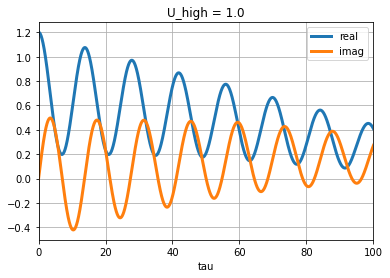

In [22]:
_ds = R.sel(U_high=1)

fig, ax = plt.subplots(1, 1)

np.real(_ds["high"]).plot.line(x="tau", label="real", lw=3)
np.imag(_ds["high"]).plot.line(x="tau", label="imag", lw=3)

ax.grid()
ax.legend(loc="upper right")
ax.set_ylabel(None)
ax.set_xlim(0, 100)

---

## things remaining to be done, questions

- show impact of a low frequency contribution on the estimate of the lag, better synthesis
- illustrate stationary case? (issue with mean in autocorrelation computation)
- illustrate effect of neighbooring stationary frequencies
- sensitivity to filter kernel length?
- show statistical accuracy of the lag/variance estimate as a function of time window ?
- can the fast decorrelation of the band-passed low frequency enveloppes be leveraged when the high frequency signal exhibit a larger correlation? Can we quantify the decorrelation timescale of the band-passed low frequency enveloppe?